In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

In [2]:
%run ./initialize.ipynb

Imported function `get_value_data(files, columns)` -> dataframe of values
Imported function `get_value_data(files, columns)` -> dataframe of returns
Imported function `initialize_data()` -> tuple of value and returns data
Imported class `Arbitrage(data : pd.DataFrame)` with methods `show_plot()`, `get_test_results()`


In [3]:
data = initialize_data()
df = data.get_ffill_data()
returns = data.get_true_return().dropna()
returns.head()

,us_agg,jpy,global_agg,gb,em_agg,ger,euro_agg,us
Date,,,,,,,,
2000-11-08,0.000624,-0.00005,-0.002368,0.000037,-0.005770,0.00010,-0.000192,-0.00011
2000-11-09,0.001960,-0.00010,0.002085,-0.000163,0.000349,-0.00021,0.000474,-0.00030
2000-11-10,0.000122,0.00004,0.000937,-0.000228,0.005363,-0.00009,0.000713,-0.00042
2000-11-13,0.002067,-0.00028,0.001797,-0.000358,0.003666,-0.00034,0.003032,-0.00017
2000-11-14,0.000787,0.00006,-0.001735,0.000177,0.002980,0.00002,-0.000744,-0.00011


In [4]:
total_return_df = df[['us_agg', 'global_agg', 'em_agg', 'euro_agg']]
yield_df = df[['jpy', 'gb', 'ger', 'us']]

## Methods to determine periods of high volatility.
- Look back 2 years, rank the rolling volatilities, and check whether we are in a 90th percentile or higher

In [5]:
def get_rolling_volatilities(data, rolling_period = 20):
    return data.rolling(rolling_period).std().dropna()

def rank_volatilities(volatility_data):
    from scipy.stats import percentileofscore
    percentiles = volatility_data.apply(lambda x: percentileofscore(volatility_data, x))
    return percentiles

def high_volatility_market(volatility_data):
    ranks = rank_volatilities(volatility_data)
    return 1 if ranks[-1] > 80 else 0    

In [6]:
def equity_curve_data(asset):
    if isinstance(asset, pd.DataFrame):
        asset = asset.apply(to_stationary, axis = 0)
        insert_row = pd.Series([0] * len(asset.columns), index = asset.columns)
        asset.iloc[0] = insert_row
    
    elif max(asset) > 0.5:
        asset = to_stationary(asset).dropna()
    
    plot_values = (asset + 1).cumprod()
    return plot_values

## Build rough strategy
Idea: If we enter a high volatility state, trade the arbitrage until we are no longer in a high volatility environment

In [7]:
class Portfolio:
    
    def __init__(self, asset_returns, weights):
        
        self.weights = weights
        self.asset_returns = asset_returns
        self.returns = (self.weights * self.asset_returns).sum(axis = 1)
        
    def plot(self):
        (self.returns + 1).cumprod().plot()

In [40]:
class Test:
    
    def __init__(self, data):
        
        self.data = data.copy()
        self.asset_rtn = data.apply(to_stationary, axis = 0)
        
        ew = data.copy().applymap(lambda x : 1 / len(data.columns))
        self.ew_portfolio = Portfolio(self.asset_rtn, ew)
        
        self.positions = self.data.applymap(lambda x: 0)
        
        rolling_volatilities = get_rolling_volatilities(self.ew_portfolio.returns, 15).dropna()
        self.high_volatility = rolling_volatilities.rolling(252).apply(high_volatility_market).dropna()

    
    def __backtest__(self):
        
        def find_positions(volatile_flag):
            enter, exit = [], []
            current_row = 0
            while current_row < len(volatile_flag):
                date, value = volatile_flag.index[current_row], volatile_flag.values[current_row]
                if value == 1:
                    ent_date, ext_date = date, date
                    while current_row < len(volatile_flag) and volatile_flag.values[current_row] == 1:
                        ext_date = volatile_flag.index[current_row]
                        current_row += 1   
                    enter.append(ent_date)
                    exit.append(ext_date)
                current_row += 1

            return [(ent, ex) for ent, ex in zip(enter, exit)]

    
        positions = find_positions(self.high_volatility)        
        length = 100
        alpha = 0.05
        for entrance, exit in positions:
            start, end = entrance - pd.Timedelta(days = length), entrance
            relevant = self.data.loc[start: end]
            arb = Arbitrage(relevant, method = 'wls')
            # if there isn't any cointegration over the past 3 months, just ignore this signal
            if arb.get_test_results()[1] > alpha:
                continue
            
            test_arb = self.data.loc[entrance: exit]
            x_test = test_arb.drop([arb.dependent], axis = 1)
            y_test = test_arb[arb.dependent]
            
            # go time step by time step - shorting / longing as needed
            current_index = 0
            while current_index < len(y_test):
                date = y_test.index[current_index]
                prediction = arb.model.predict(x_test.iloc[current_index])[0]
                true = y_test[current_index]
                deviation = true - prediction
                total_assets = len(x_test.iloc[current_index]) + 1
                
                # arbitrage
                if deviation > 0:
                    long_assets = total_assets - 1
                    pos = pd.Series([1 / long_assets] * total_assets, index = self.data.columns)
                    pos.loc[arb.dependent] = -1
                    self.positions.loc[date] = pos
                
                elif deviation < 0:
                    short_assets = total_assets - 1
                    pos = pd.Series([-1 / short_assets] * total_assets, index = self.data.columns)
                    pos.loc[arb.dependent] = 1
                    self.positions.loc[date] = pos
                
                current_index += 1
                    

In [41]:
item = Test(yield_df)

In [42]:
item.__backtest__()

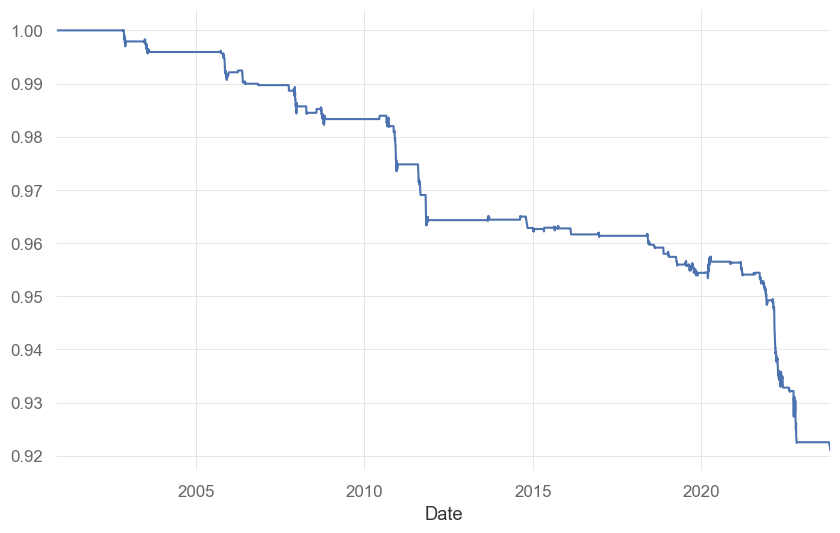

In [43]:
rtnz = returns[item.positions.columns]
Portfolio(rtnz, item.positions).plot()